# Importing libraries

In [1]:
import os
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import random
from imageio import imread

Using TensorFlow backend.


# Loading the dataset

In [2]:
data_dir = os.path.abspath('C:/Users/asadb/Downloads/GTSRB/Final_Training/Images')
os.path.exists(data_dir)


# Function to resize the images using open cv
def resize_cv(im):
    return cv2.resize(im, (64, 64), interpolation=cv2.INTER_LINEAR)


# Loading datset
list_images = []
output = []
for dir in os.listdir(data_dir):
    if dir == '.DS_Store':
        continue

    inner_dir = os.path.join(data_dir, dir)
    csv_file = pd.read_csv(os.path.join(inner_dir, "GT-" + dir + '.csv'), sep=';')
    for row in csv_file.iterrows():
        img_path = os.path.join(inner_dir, row[1].Filename)
        img = imread(img_path)
        img = img[row[1]['Roi.X1']:row[1]['Roi.X2'], row[1]['Roi.Y1']:row[1]['Roi.Y2'], :]
        img = resize_cv(img)
        list_images.append(img)
        output.append(row[1].ClassId)

### Plotting the dataset

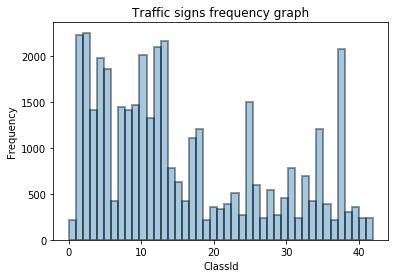

In [3]:
fig = sns.distplot(output, kde=False, bins=43, hist=True, hist_kws=dict(edgecolor="black", linewidth=2))
fig.set(title="Traffic signs frequency graph",
        xlabel="ClassId",
        ylabel="Frequency")

input_array = np.stack(list_images)
out_put = np.array(output)

### Randomizing the dataset

In [4]:
randomize = np.arange(len(input_array))
np.random.shuffle(randomize)
x = input_array[randomize]
y = out_put[randomize]

### Splitting the dataset in train, validation, test set

In [5]:

split_size = int(x.shape[0] * 0.6)
X_train, x_valid = x[:split_size], x[split_size:]
y_train, y_valid = y[:split_size], y[split_size:]

split_size = int(x_valid.shape[0] * 0.5)
x_valid, x_test = x_valid[:split_size], x_valid[split_size:]
y_valid, y_test = y_valid[:split_size], y_valid[split_size:]

print(X_train.shape)

(23525, 64, 64, 3)


- We have 34799 images in training dataset having 32x32 shape and 3 color channels (RGB)

## Performing images visualization

8

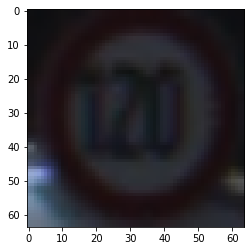

In [6]:
i = np.random.randint(1, len(X_train))
plt.imshow(X_train[i])
y_train[i]

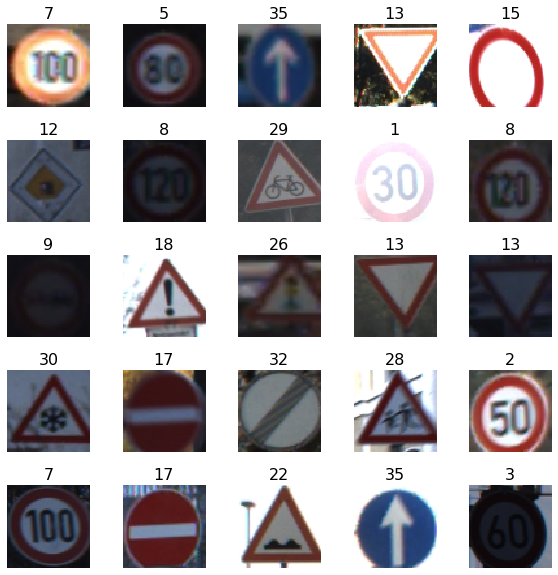

In [7]:
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 5 x 5 matrix into 25 array

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, len(X_train))
       
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index], fontsize = 16)
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

## Converting images to grayscale

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

X_train_gray = np.sum(X_train / 3, axis=3, keepdims=True)
x_valid_gray = np.sum(x_valid / 3, axis=3, keepdims=True)
x_test_gray = np.sum(x_test / 3, axis=3, keepdims=True)

### Normalizing images

In [9]:
X_train_gray_norm = (X_train_gray - 128) / 128
x_valid_gray_norm = (x_valid_gray - 128) / 128
x_test_gray_norm = (x_test_gray - 128) / 128
#
print(X_train_gray_norm.shape)

(23525, 64, 64, 1)


- Now the images have only 1 color channel (grayscale)

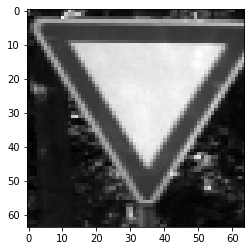

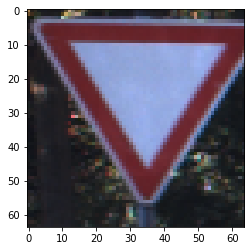

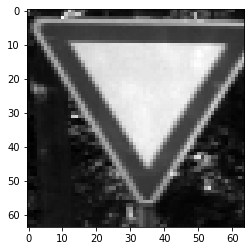

In [10]:
i = random.randint(1, len(X_train_gray))
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap='gray')

# Build CNN Model

In [11]:
from tensorflow.keras import datasets, layers, models

CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(64, 64, 1)))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5, 5), activation='relu'))
CNN.add(layers.MaxPooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation='relu'))
CNN.add(layers.Dense(84, activation='relu'))
CNN.add(layers.Dense(43, activation='softmax'))

CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 6)         0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               3

# Compile and train CNN model

In [12]:
CNN.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = CNN.fit(X_train_gray_norm,
                  y_train,
                  batch_size=500,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_valid_gray_norm, y_valid))

Train on 23525 samples, validate on 7842 samples
Epoch 1/50
23525/23525 [==============================] - 10s 430us/sample - loss: 3.0921 - accuracy: 0.2027 - val_loss: 2.4424 - val_accuracy: 0.3359
Epoch 2/50
23525/23525 [==============================] - 4s 189us/sample - loss: 1.9013 - accuracy: 0.4942 - val_loss: 1.5841 - val_accuracy: 0.5677
Epoch 3/50
23525/23525 [==============================] - 4s 184us/sample - loss: 1.2461 - accuracy: 0.6620 - val_loss: 1.1306 - val_accuracy: 0.6801
Epoch 4/50
23525/23525 [==============================] - 4s 183us/sample - loss: 0.9236 - accuracy: 0.7491 - val_loss: 0.9222 - val_accuracy: 0.7323
Epoch 5/50
23525/23525 [==============================] - 4s 185us/sample - loss: 0.7721 - accuracy: 0.7920 - val_loss: 0.7343 - val_accuracy: 0.8026
Epoch 6/50
23525/23525 [==============================] - 4s 183us/sample - loss: 0.6224 - accuracy: 0.8339 - val_loss: 0.6031 - val_accuracy: 0.8539
Epoch 7/50
23525/23525 [==========================

<!-- # Test the trained model -->

# Evaluate the trained model

In [14]:
score = CNN.evaluate(x_test_gray_norm, y_test)
print('Test Accuracy: {}'.format(score[1]))

7842/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.9732211232185364


## Visualizing training performance

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

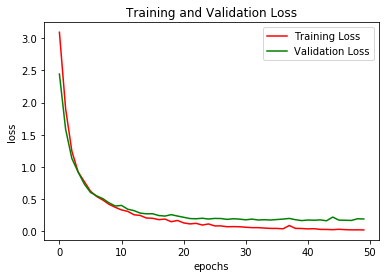

In [16]:
epochs = range(len(accuracy))
plt.plot(epochs, loss, 'r-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'g-', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

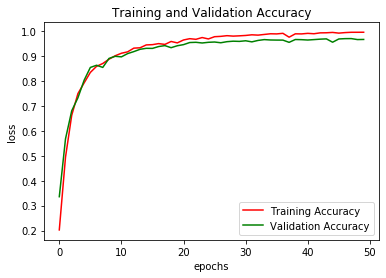

In [17]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r-', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'g-', label = 'Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Accuracy')

In [18]:
# predicted_classes = CNN.predict_classes(x_test_gray_norm)
# y_true = y_test

In [19]:
# L = 5
# W = 5

# fig, axes = plt.subplots(L, W, figsize = (12, 12))
# axes = axes.ravel()

# for i in np.arange(0, L*W):
#     index = np.random.randint(0, len(x_test))
#     axes[i].imshow(x_test[index])
#     axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[index], y_true[index]))
#     axes[i].axis('off')

# plt.subplots_adjust(wspace = 1)    

## Save the trained model

In [20]:
CNN.save('myModel.h5')

## Load the model

In [21]:
loaded_model = tf.keras.models.load_model('myModel.h5')

## Evaluate Test Data on Loaded Model

In [22]:
loaded_model_score = loaded_model.evaluate(x_test_gray_norm, y_test)
print('Test Accuracy: {}'.format(loaded_model_score[1]))

7842/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy: 0.9732211232185364


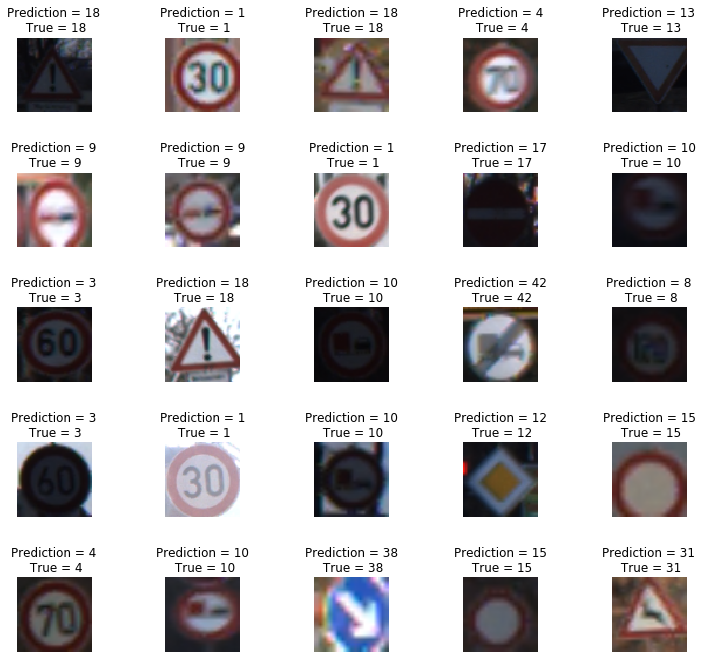

In [23]:
predicted_classes_from_loaded_model = loaded_model.predict_classes(x_test_gray_norm)
y_true = y_test

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    index = np.random.randint(0, len(x_test))
    axes[i].imshow(x_test[index])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes_from_loaded_model[index], y_true[index]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

# APPENDIX

- The dataset consists of 43 different classes of images. 
- Classes are as listed below: 
  - 0 = Speed limit (20km/h) 
  - 1 = Speed limit (30km/h)
  - 2 = Speed limit (50km/h) 
  - 3 = Speed limit (60km/h)
  - 4 = Speed limit (70km/h) 
  - 5 = Speed limit (80km/h)
  - 6 = End of speed limit (80km/h)
  - 7 = Speed limit (100km/h)
  - 8 = Speed limit (120km/h)
  - 9 = No passing
  - 10 = No passing for vehicles over 3.5 metric tons
  - 11 = Right-of-way at the next intersection
  - 12 = Priority road
  - 13 = Yield
  - 14 = Stop
  - 15 = No vehicles
  - 16 = Vehicles over 3.5 metric tons prohibited
  - 17 = No entry
  - 18 = General caution
  - 19 = Dangerous curve to the left
  - 20 = Dangerous curve to the right
  - 21 = Double curve
  - 22 = Bumpy road
  - 23 = Slippery road
  - 24 = Road narrows on the right
  - 25 = Road work
  - 26 = Traffic signals
  - 27 = Pedestrians
  - 28 = Children crossing 
  - 29 = Bicycles crossing
  - 30 = Beware of ice/snow
  - 31 = Wild animals crossing
  - 32 = End of all speed and passing limits
  - 33 = Turn right ahead
  - 34 = Turn left ahead
  - 35 = Ahead only
  - 36 = Go straight or right
  - 37 = Go straight or left
  - 38 = Keep right
  - 39 = Keep left
  - 40 = Roundabout mandatory
  - 41 = End of no passing
  - 42 = End of no passing by vehicles over 3.5 metric tons

- Citation
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 
